In [ ]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rich.progress import track

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

In [2]:
training_data = pd.read_csv('../data/training_data.csv')
test_data = pd.read_csv('../data/testing_data.csv')

X_train = training_data.iloc[:, :-1]
y_train = training_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

In [3]:
X_train.describe()

,stock_price,strike_price,time_to_maturity,interest_rate,volatility,dividend_yield,1_over_T,log_T,sqrt_T,log1p_T,...,dividend_yield_over_interest_times_interest_rate_over_volatility,dividend_yield_over_interest_times_dividend_yield_over_volatility,dividend_yield_over_interest_times_stock_price_over_volatility,stock_price_over_interest_times_interest_rate_over_volatility,stock_price_over_interest_times_dividend_yield_over_volatility,stock_price_over_interest_times_stock_price_over_volatility,interest_rate_over_volatility_times_dividend_yield_over_volatility,interest_rate_over_volatility_times_stock_price_over_volatility,dividend_yield_over_volatility_times_stock_price_over_volatility,option_type_put
count,107100.000000,107100.0,107100.000000,107100.000000,107100.000000,107100.000000,107100.000000,107100.000000,107100.000000,107100.000000,...,107100.000000,107100.000000,107100.000000,107100.000000,107100.000000,107100.000000,107100.000000,107100.000000,107100.000000,107100.000000
mean,-0.000788,0.0,0.000985,-0.002128,0.000416,-0.001421,-0.001447,0.001421,0.001219,0.001228,...,0.000672,0.002024,0.001969,-0.001065,0.001969,0.001684,-0.000962,-0.003104,-0.000016,0.500626
std,0.999031,0.0,0.999816,0.999851,1.000753,1.000701,0.998478,0.999164,0.999534,0.999541,...,1.002408,1.002335,1.004918,0.997789,1.004918,1.003749,0.999149,0.994460,0.999869,0.500002
min,-1.698416,0.0,-1.215881,-1.286384,-1.249390,-1.463850,-0.549325,-2.131798,-1.607082,-1.559374,...,-0.849597,-0.457952,-0.517476,-0.966835,-0.517476,-0.580186,-0.450090,-0.539460,-0.525098,0.000000
25%,-0.883176,0.0,-0.947531,-0.826961,-0.858956,-0.878310,-0.512426,-0.671972,-0.914853,-0.969502,...,-0.641533,-0.435707,-0.467015,-0.715225,-0.467015,-0.491998,-0.439451,-0.506401,-0.500410,0.000000
50%,0.000000,0.0,0.010862,-0.061256,-0.078087,-0.292770,-0.466303,0.432344,0.238861,0.275135,...,-0.433468,-0.324483,-0.340517,-0.442647,-0.340517,-0.347170,-0.386254,-0.434272,-0.439899,1.000000
75%,0.883176,0.0,0.649790,0.704448,0.702782,0.878310,-0.051197,0.755336,0.757444,0.791707,...,0.190726,-0.040860,0.013403,0.479923,0.013403,0.041965,-0.130909,-0.023135,-0.021649,1.000000
max,1.698416,0.0,1.927648,1.470153,1.483651,1.463850,2.854551,1.162257,1.579798,1.519773,...,3.311696,7.883903,9.851251,3.051936,9.851251,7.589146,5.933540,5.227877,5.283929,1.000000


In [4]:
# Dropping columns with no change in values
Columns_variance_filter = X_train.loc[:, X_train.var() > 1e-2].columns.tolist()

# Dropping columns with low correlation to the target variable
df = X_train.copy()
df["y"] = y_train
corr = df.corr()
Columns_correlation_filter = corr["y"].abs()[corr["y"].abs() > 0.05].index.tolist()

# Selecting top 40 features using mutual information regression
Feature_selection = SelectKBest(mutual_info_regression, k=40).fit(X_train, y_train)
Top_40_columns = X_train.columns[Feature_selection.get_support(indices=True)]

top_variables = set(Top_40_columns).intersection(set(Columns_variance_filter).intersection(set(Columns_correlation_filter)))

X_train_top_vars = X_train[list(top_variables)]
X_test_top_vars = X_test[list(top_variables)]

In [5]:
pca_full = PCA(random_state=2025)
pca_full.fit(X_train)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

Var_threshold = 0.98
Number_of_components = np.where(cum_var > Var_threshold)[0][0]
print(
    f"Number of components to explain {Var_threshold} variance: {Number_of_components}"
)

pca = PCA(n_components=Number_of_components, random_state=2025)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Plotting the explained variance ratio
# plt.figure(figsize=(8, 4))
# plt.plot(range(1, len(cum_var) + 1), cum_var)
# plt.xlabel("Number of Principal Components")
# plt.ylabel("Cumulative Explained Variance")
# plt.title("PCA: How Much Variance vs. # Components")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

Number of components to explain 0.98 variance: 22


In [6]:
data_modes = {
    "all_variables": {
        "X_train": X_train,
        "X_test": X_test,
    },
    "top_vars": {
        "X_train": X_train_top_vars,
        "X_test": X_test_top_vars,
    },
    "pca": {
        "X_train": X_train_pca,
        "X_test": X_test_pca,
    },
}

In [7]:
results = []
detailed_results = []

In [31]:
family_name = "linear_models"
print(f"Running {family_name} family:\n")


linear_models = {
    "LinearRegression": {
        "model": LinearRegression(),
        "grid": {"fit_intercept": [True, False]},
    },
    "Ridge": {"model": Ridge(), "grid": {"alpha": [0.1, 1.0, 10.0]}},
}

for model_name, settings in linear_models.items():
    print(f"Running {model_name} model:\n")
    for data_mode, data in track(
        data_modes.items(), description=f"data mode {data_mode}"
    ):
        X_train_temp = data_modes[data_mode]["X_train"]
        X_test_temp = data_modes[data_mode]["X_test"]

        model = settings["model"]
        param_grid = settings["grid"]
        gs = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring="neg_root_mean_squared_error",
            cv=3,
            n_jobs=-1,
            verbose=10,
        )

        start = time.time()
        gs.fit(X_train_temp, y_train)
        elapsed = time.time() - start

        best = gs.best_estimator_
        train_rmse = root_mean_squared_error(y_train, best.predict(X_train_temp))
        test_rmse = root_mean_squared_error(y_test, best.predict(X_test_temp))

        detailed_results.append(
            {
                "family": family_name,
                "model": model_name,
                "data_mode": data_mode,
                "gs_object": gs,
                "best_estimator": best,
            }
        )

        results.append(
            {
                "family": family_name,
                "model": model_name,
                "data_mode": data_mode,
                "train_rmse": train_rmse,
                "test_rmse": test_rmse,
                "time_s": elapsed,
            }
        )

Output()

Fitting 3 folds for each of 2 candidates, totalling 6 fits

Running linear_models family:

Running LinearRegression model:



Fitting 3 folds for each of 2 candidates, totalling 6 fits

Fitting 3 folds for each of 2 candidates, totalling 6 fits

Output()

Fitting 3 folds for each of 3 candidates, totalling 9 fits

Running Ridge model:



Fitting 3 folds for each of 3 candidates, totalling 9 fits

Fitting 3 folds for each of 3 candidates, totalling 9 fits

In [ ]:
family_name = "tree_models"
print(f"Running {family_name} family:\n")


tree_models = {
    "RandomForestRegressor": {
        "model": RandomForestRegressor(random_state=2025),
        "grid": {"n_estimators": [10, 40], "max_depth": [5, 10]},
    },
    "XGBRegressor": {
        "model": XGBRegressor(tree_method="hist", random_state=2025, verbosity=1),
        "grid": {
            "n_estimators": [10, 40],
            "learning_rate": [0.01, 0.1],
            "max_depth": [2, 6],
        },
    },
}

for model_name, settings in tree_models.items():
    print(f"Running {model_name} model:\n")
    for data_mode, data in track(
        data_modes.items(), description=f"data mode {data_mode}"
    ):
        # if data_mode == "all_variables":
        #     #skipping this combination as it takes too long
        #     continue

        X_train_temp = data_modes[data_mode]["X_train"]
        X_test_temp = data_modes[data_mode]["X_test"]

        model = settings["model"]
        param_grid = settings["grid"]
        gs = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring="neg_root_mean_squared_error",
            cv=3,
            n_jobs=-1,
            verbose=10,
        )

        start = time.time()
        if data_mode == "all_variables":
            # sampling 10% of the data for faster computation
            ratio = 0.5
            full_len = len(X_train_temp)
            sample_size = int(ratio*full_len)
            sample_indices = np.random.choice(size = , replace=False)
            sample_size = int(X_train_temp.shape[0] * 0.1)
            sample_indices = np.random.choice(
                X_train_temp.shape[0], size=sample_size, replace=False
            )

            gs.fit(X_train_temp.iloc[sample_indices], y_train.iloc[sample_indices])

        else:
            gs.fit(X_train_temp, y_train)
        elapsed = time.time() - start

        best = gs.best_estimator_
        train_rmse = root_mean_squared_error(y_train, best.predict(X_train_temp))
        test_rmse = root_mean_squared_error(y_test, best.predict(X_test_temp))

        detailed_results.append(
            {
                "family": family_name,
                "model": model_name,
                "data_mode": data_mode,
                "gs_object": gs,
                "best_estimator": best,
            }
        )

        results.append(
            {
                "family": family_name,
                "model": model_name,
                "data_mode": data_mode,
                "train_rmse": train_rmse,
                "test_rmse": test_rmse,
                "time_s": elapsed,
            }
        )

Output()

Fitting 3 folds for each of 4 candidates, totalling 12 fits

Running tree_models family:

Running RandomForestRegressor model:



Fitting 3 folds for each of 4 candidates, totalling 12 fits

Output()

Fitting 3 folds for each of 8 candidates, totalling 24 fits

Running XGBRegressor model:



Fitting 3 folds for each of 8 candidates, totalling 24 fits

In [44]:
family_name = "kernel_models"
print(f"Running {family_name} family:\n")


kernel_models = {
    "SVR": {
        "model": SVR(),
        "grid": {
            "kernel": ["linear", "poly", "rbf"],
            "C": [0.1, 1.0, 10.0],
            "gamma": ["scale", "auto"],
        },
    },
    "KNeighborsRegressor": {
        "model": KNeighborsRegressor(),
        "grid": {
            "n_neighbors": [3, 5, 10],
            "leaf_size": [10, 20],
            "weights": ["uniform", "distance"],
        },
    },
}

for model_name, settings in kernel_models.items():
    print(f"Running {model_name} model:\n")
    for data_mode, data in track(
        data_modes.items(), description=f"data mode {data_mode}"
    ):
        if data_mode == "all_variables":
            # skipping this combination as it takes too long
            continue

        size_reduction_factor = 0.1
        size_limit = int(len(X_train) * size_reduction_factor)

        X_train_temp = data_modes[data_mode]["X_train"]
        X_test_temp = data_modes[data_mode]["X_test"]

        model = settings["model"]
        param_grid = settings["grid"]
        gs = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring="neg_root_mean_squared_error",
            cv=3,
            n_jobs=-1,
            verbose=10,
        )

        start = time.time()
        if model_name == "SVR":
            # SVR is slow, so we limit the size of the training set
            gs.fit(X_train_temp[0:size_limit], y_train[0:size_limit])
        else:
            # KNeighborsRegressor is also slow, but we can use the full dataset
            gs.fit(X_train_temp, y_train)
        elapsed = time.time() - start

        best = gs.best_estimator_
        train_rmse = root_mean_squared_error(y_train, best.predict(X_train_temp))
        test_rmse = root_mean_squared_error(y_test, best.predict(X_test_temp))

        detailed_results.append(
            {
                "family": family_name,
                "model": model_name,
                "data_mode": data_mode,
                "gs_object": gs,
                "best_estimator": best,
            }
        )

        results.append(
            {
                "family": family_name,
                "model": model_name,
                "data_mode": data_mode,
                "train_rmse": train_rmse,
                "test_rmse": test_rmse,
                "time_s": elapsed,
            }
        )

Output()

Fitting 3 folds for each of 3 candidates, totalling 9 fits

Running kernel_models family:

Running SVR model:



Fitting 3 folds for each of 3 candidates, totalling 9 fits

Output()

Fitting 3 folds for each of 12 candidates, totalling 36 fits

Running KNeighborsRegressor model:



Fitting 3 folds for each of 12 candidates, totalling 36 fits

In [ ]:
family_name = "neural_networks"
print(f"Running {family_name} family:\n")

neural_networks = {
    "MLPRegressor": {
        "model": MLPRegressor(max_iter=100, random_state=2025),
        "grid": {
            "hidden_layer_sizes": [(50,), (100), (50,50,50,50,), (100, 100)],
            "alpha": [1e-4, 1e-3, 1e-2],
            "learning_rate": ["constant", "adaptive"],
        },
    },
}

for model_name, settings in kernel_models.items():
    print(f"Running {model_name} model:\n")
    for data_mode, data in track(
        data_modes.items(), description=f"data mode {data_mode}"
    ):
        if data_mode == "all_variables":
            # skipping this combination as it takes too long
            continue

        X_train_temp = data_modes[data_mode]["X_train"]
        X_test_temp = data_modes[data_mode]["X_test"]

        model = settings["model"]
        param_grid = settings["grid"]
        gs = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring="neg_root_mean_squared_error",
            cv=3,
            n_jobs=-1,
            verbose=10,
        )

        start = time.time()
        gs.fit(X_train_temp, y_train)
        elapsed = time.time() - start

        best = gs.best_estimator_
        train_rmse = root_mean_squared_error(y_train, best.predict(X_train_temp))
        test_rmse = root_mean_squared_error(y_test, best.predict(X_test_temp))

        detailed_results.append(
            {
                "family": family_name,
                "model": model_name,
                "data_mode": data_mode,
                "gs_object": gs,
                "best_estimator": best,
            }
        )

        results.append(
            {
                "family": family_name,
                "model": model_name,
                "data_mode": data_mode,
                "train_rmse": train_rmse,
                "test_rmse": test_rmse,
                "time_s": elapsed,
            }
        )

In [22]:
results = []
for mname, mspec in model_specs.items():
    for sname, selector in selectors.items():
        pipe = Pipeline([("selector", selector), ("model", mspec["est"])])

        # merge the selector choice (no params) with the model’s grid
        param_grid = {**{f"selector": [selector]}, **mspec["grid"]}

        gs = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            scoring="neg_root_mean_squared_error",
            cv=3,
            n_jobs=-1,
        )

        t0 = time.time()
        gs.fit(X_train, y_train)
        elapsed = time.time() - t0

        best = gs.best_estimator_
        train_rmse = root_mean_squared_error(y_train, best.predict(X_train))
        test_rmse = root_mean_squared_error(y_test, best.predict(X_test))

        # if we used SelectKBest, capture which features were kept
        if isinstance(best.named_steps["selector"], SelectKBest):
            mask = best.named_steps["selector"].get_support()
            feats = X_train.columns[mask].tolist()
        else:
            feats = None

        results.append(
            {
                "model": mname,
                "selector": sname,
                "train_rmse": train_rmse,
                "test_rmse": test_rmse,
                "time_s": elapsed,
                "best_params": gs.best_params_,
                "features": feats,
            }
        )

In [24]:
df_res = pd.DataFrame(results)
df_res.to_csv("../data/model_comparison.csv", index=False)

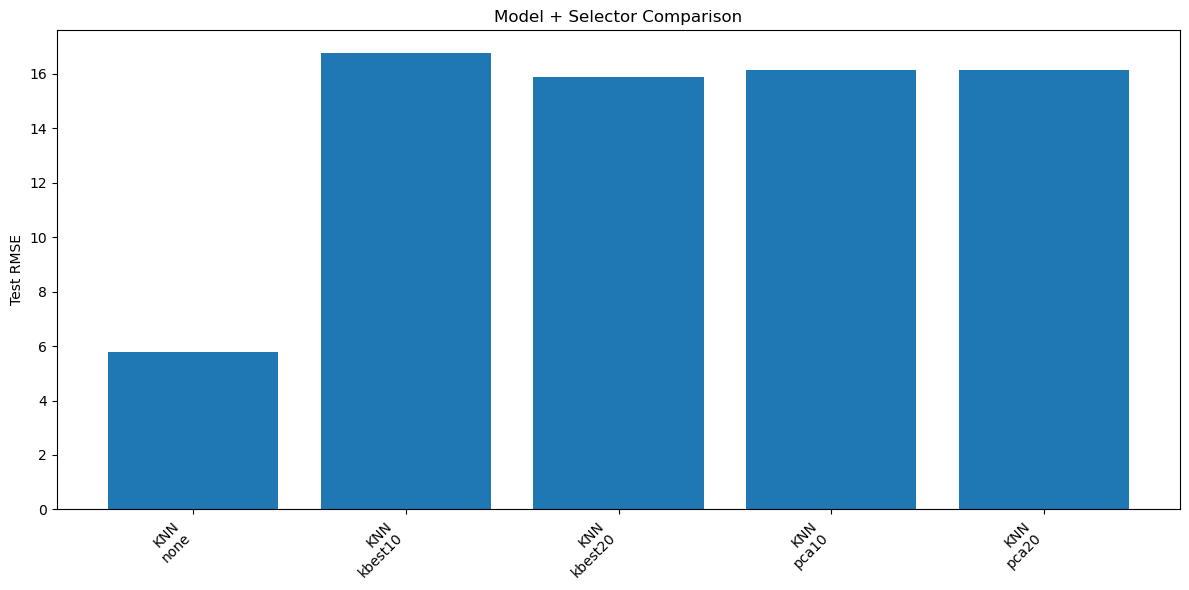

In [25]:
plt.figure(figsize=(12, 6))
labels = df_res["model"] + "\n" + df_res["selector"]
plt.bar(x=np.arange(len(df_res)), height=df_res["test_rmse"], tick_label=labels)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Test RMSE")
plt.title("Model + Selector Comparison")
plt.tight_layout()
plt.show()

In [ ]:
for row in results:
    if row["features"]:
        out = pd.Series(row["features"], name="feature")
        fname = f"../reports/{row['model']}_{row['selector']}_top_feats.csv"
        out.to_csv(fname, index=False)